# Prometheus - Western Engineering Rocketry Team 2022

Launched at Spaceport America Cup 2022 edition.  
Western Engineering Rocketry Team is a rocket design team from Western University in London, Ontario (Canada).
Permission to use flight data given by Giorgio Chassikos, 2024.

Website: [https://www.werocketry.com/](https://www.werocketry.com/)

## Team Information:
The Western Engineering Rocketry Team is a student-led engineering design team founded in 2016 at Western University in London, Ontario.  
Comprised of engineering students from a variety of disciplines, the team's goal is to develop and launch rockets through the Intercollegiate Rocket Engineering Competition.

## Flight Card Results:
1. **Launch Date:** June 24th, 2022, 9:17am local time
2. **Last Simulated Apogee:** 4190.05 m
3. **Official Recorded Apogee:** 3898.37 m

If we calculate the simulation error and divide it by the actual apogee, we get a relative error of 7.48%.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from rocketpy import Environment, Flight, Function, GenericMotor, Rocket
from rocketpy.simulation.flight_data_importer import FlightDataImporter

plt.style.use("seaborn-v0_8-colorblind")

## Define the Environment

In [4]:
env = Environment(
    latitude=32.939377,
    longitude=-106.911986,
    elevation=1401,
)
env.set_date(date=(2023, 6, 24, 9), timezone="America/Denver")

env.set_atmospheric_model(
    type="Reanalysis",
    file="../../data/weather/spaceport_america_pressure_levels_2023_hourly.nc",
    dictionary="ECMWF",
)

env.max_expected_height = 6000


Gravity Details

Acceleration of gravity at surface level:    9.7913 m/s²
Acceleration of gravity at   6.000 km (ASL): 9.7771 m/s²


Launch Site Details

Launch Date: 2023-06-24 15:00:00 UTC | 2023-06-24 09:00:00 America/Denver
Launch Site Latitude: 32.93938°
Launch Site Longitude: -106.91199°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 321254.52 W    3646188.36 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1401.0 m


Atmospheric Model Details

Atmospheric Model Type: Reanalysis
Reanalysis Maximum Height: 6.000 km
Reanalysis Time Period: from 2023-06-19 00:00:00 to 2023-06-24 23:00:00 utc
Reanalysis Hour Interval: 1 hrs
Reanalysis Latitude Range: From 36.75° to 29.0°
Reanalysis Longitude Range: From -108.87999725341797° to -105.12999725341797°

Surface Atmospheric Conditions

Surface Wind Speed: 0.20 m/s
Surface Wind Direction: 304.58°
Surface Wind Heading: 124.58°
Surface Pressure: 861.95 hPa
Surface Temperature: 299.96 K
Surface Air Density: 1.001 kg/m³
Sur

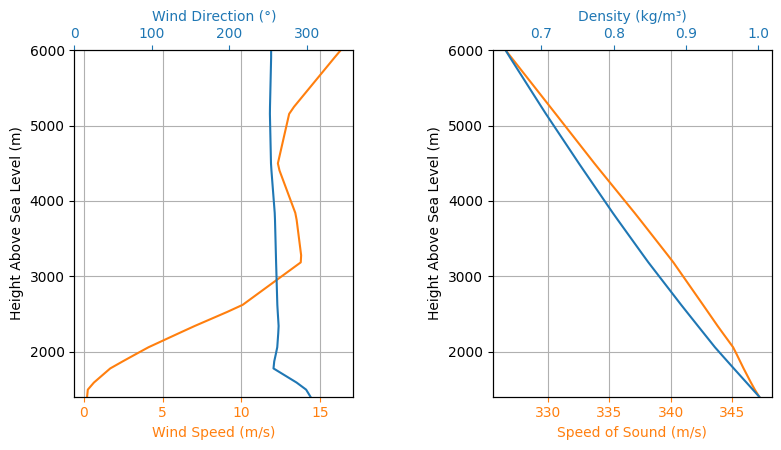

In [5]:
env.info()

## Define the motor

Motor Details
Total Burning Time: 4.897 s
Total Propellant Mass: 3.737 kg
Structural Mass Ratio: 0.444
Average Propellant Exhaust Velocity: 2028.119 m/s
Average Thrust: 1547.699 N
Maximum Thrust: 1827.113 N at 1.652 s after ignition.
Total Impulse: 7579.081 Ns



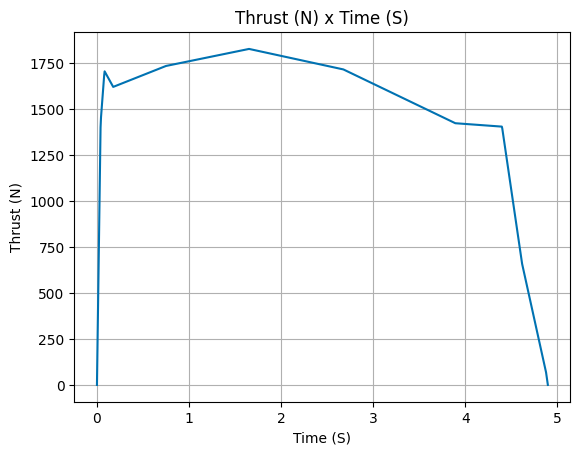

In [6]:
motor_M1520 = GenericMotor(
    # burn specs: https://www.thrustcurve.org/simfiles/5f4294d20002e900000006b1/
    thrust_source="../../data/motors/cesaroni/Cesaroni_7579M1520-P.eng",
    burn_time=4.897,
    propellant_initial_mass=3.737,
    dry_mass=2.981,
    # casing specs: Pro98 3G Gen2 casing
    chamber_radius=0.064,
    chamber_height=0.548,
    chamber_position=0.274,
    nozzle_radius=0.027,
)


motor_M1520.info()

## Define the Rocket

In [7]:
def prometheus_cd_at_ma(mach):
    """Gives the drag coefficient of the rocket at a given mach number."""
    if mach <= 0.15:
        return 0.422
    elif mach <= 0.45:
        return 0.422 + (mach - 0.15) * (0.38 - 0.422) / (0.45 - 0.15)
    elif mach <= 0.77:
        return 0.38 + (mach - 0.45) * (0.32 - 0.38) / (0.77 - 0.45)
    elif mach <= 0.82:
        return 0.32 + (mach - 0.77) * (0.3 - 0.32) / (0.82 - 0.77)
    elif mach <= 0.88:
        return 0.3 + (mach - 0.82) * (0.3 - 0.3) / (0.88 - 0.82)
    elif mach <= 0.94:
        return 0.3 + (mach - 0.88) * (0.32 - 0.3) / (0.94 - 0.88)
    elif mach <= 0.99:
        return 0.32 + (mach - 0.94) * (0.37 - 0.32) / (0.99 - 0.94)
    elif mach <= 1.04:
        return 0.37 + (mach - 0.99) * (0.44 - 0.37) / (1.04 - 0.99)
    elif mach <= 1.24:
        return 0.44 + (mach - 1.04) * (0.43 - 0.44) / (1.24 - 1.04)
    elif mach <= 1.33:
        return 0.43 + (mach - 1.24) * (0.42 - 0.43) / (1.33 - 1.24)
    elif mach <= 1.49:
        return 0.42 + (mach - 1.33) * (0.39 - 0.42) / (1.49 - 1.33)
    else:
        return 0.39


prometheus = Rocket(
    radius=0.06985,  # 5.5" diameter circle
    mass=13.93,
    inertia=(
        4.87,
        4.87,
        0.05,
    ),
    power_off_drag=prometheus_cd_at_ma,
    power_on_drag=lambda x: prometheus_cd_at_ma(x) * 1.02,  # 5% increase in drag
    center_of_mass_without_motor=0.9549,
    coordinate_system_orientation="tail_to_nose",
)

prometheus.set_rail_buttons(0.69, 0.21, 60)

prometheus.add_motor(motor=motor_M1520, position=0)
nose_cone = prometheus.add_nose(length=0.742, kind="Von Karman", position=2.229)
fin_set = prometheus.add_trapezoidal_fins(
    n=3,
    span=0.13,
    root_chord=0.268,
    tip_chord=0.136,
    position=0.273,
    sweep_length=0.066,
)
drogue = prometheus.add_parachute(
    "Drogue",
    cd_s=1.6 * np.pi * 0.3048**2,  # Cd = 1.6, D_chute = 24 in
    trigger="apogee",
)
main = prometheus.add_parachute(
    "Main",
    cd_s=2.2 * np.pi * 0.9144**2,  # Cd = 2.2, D_chute = 72 in
    trigger=457.2,  # 1500 ft
)


Inertia Details

Rocket Mass: 13.930 kg (without motor)
Rocket Dry Mass: 16.911 kg (with unloaded motor)
Rocket Loaded Mass: 20.648 kg
Rocket Structural Mass Ratio: 0.819
Rocket Inertia (with unloaded motor) 11: 6.008 kg*m2
Rocket Inertia (with unloaded motor) 22: 6.008 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.050 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.06985 m
Rocket Frontal Area: 0.015328 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.120 m
Rocket Center of Dry Mass - Nozzle Exit: 0.835 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.561 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.102 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 6.406/rad

Center of Pressure

No

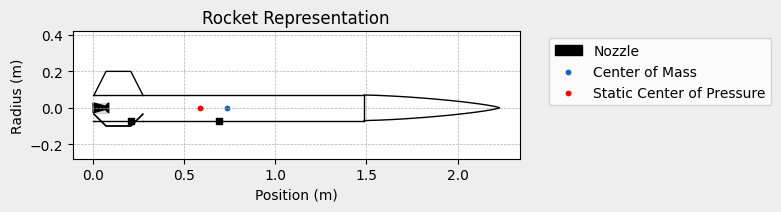

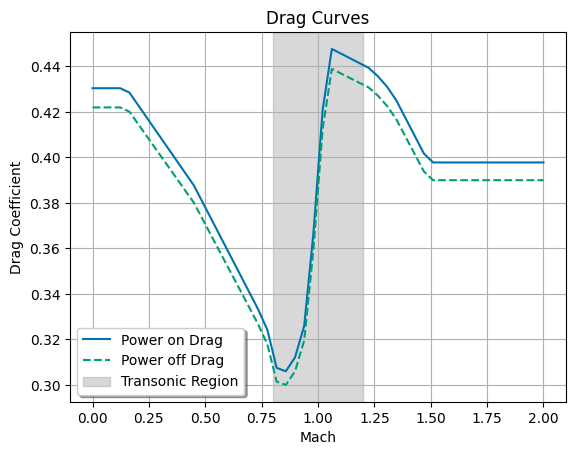

In [8]:
prometheus.info()
prometheus.draw()
prometheus.plots.drag_curves()

## Simulate the Flight

In [9]:
test_flight = Flight(
    rocket=prometheus,
    environment=env,
    inclination=80,
    heading=75,
    rail_length=5.18,
)

In [10]:
# test_flight.prints.initial_conditions()
# test_flight.prints.surface_wind_conditions()
# test_flight.prints.launch_rail_conditions()
test_flight.prints.out_of_rail_conditions()
test_flight.prints.burn_out_conditions()
test_flight.prints.apogee_conditions()
# test_flight.prints.events_registered()
# test_flight.prints.impact_conditions()
test_flight.prints.stability_margin()
test_flight.prints.maximum_values()
# test_flight.prints.numerical_integration_settings()


Rail Departure State

Rail Departure Time: 0.385 s
Rail Departure Velocity: 25.256 m/s
Rail Departure Stability Margin: 1.090 c
Rail Departure Angle of Attack: 0.455°
Rail Departure Thrust-Weight Ratio: 8.326
Rail Departure Reynolds Number: 1.911e+05

Burn out State

Burn out time: 4.897 s
Altitude at burn out: 2271.603 m (ASL) | 870.603 m (AGL)
Rocket speed at burn out: 328.212 m/s
Freestream velocity at burn out: 326.880 m/s
Mach Number at burn out: 0.950
Kinetic energy at burn out: 9.109e+05 J

Apogee State

Apogee Time: 29.107 s
Apogee Altitude: 5589.810 m (ASL) | 4188.810 m (AGL)
Apogee Freestream Speed: 36.164 m/s
Apogee X position: 1530.378 m
Apogee Y position: 430.742 m
Apogee latitude: 32.9432492°
Apogee longitude: -106.8955882°

Stability Margin

Initial Stability Margin: 1.042 c at 0.00 s
Out of Rail Stability Margin: 1.090 c at 0.38 s
Maximum Stability Margin: 1.886 c at 4.90 s
Minimum Stability Margin: 1.042 c at 0.00 s

Maximum Values

Maximum Speed: 330.260 m/s at 4.73 

## Read the Telemetry Data

In [11]:
columns_map = {
    "time": "time",
    "altitude": "z",
    "height": "altitude",
    "acceleration": "acceleration",
    "pressure": "pressure",
    "accel_x": "ax",
    "accel_y": "ay",
    "accel_z": "az",
    "latitude": "latitude",
    "longitude": "longitude",
}


cots_altimeter_flight = FlightDataImporter(
    name="Telemetry Mega",
    paths="../../data/rockets/prometheus/2022-06-24-serial-5115-flight-0001-TeleMetrum.csv",
    columns_map=columns_map,
    units=None,
    interpolation="linear",
    extrapolation="zero",
    delimiter=",",
    encoding="utf-8",
)

The following attributes were create and are now available to be used:  ['time', 'z', 'altitude', 'acceleration', 'pressure', 'latitude', 'longitude']


## Compare Simulation and Telemetry Data

In [12]:
real_apogee = cots_altimeter_flight.altitude.max
rocketpy_apogee = test_flight.apogee - test_flight.env.elevation
a_error = abs(real_apogee - rocketpy_apogee)
r_error = a_error / real_apogee * 100

print(f"RocketPy apogee: {rocketpy_apogee:.2f} m")
print(f"Real apogee: {real_apogee:.2f} m")
print(f"Absolute error: {a_error:.2f} m")
print(f"Relative error: {r_error:.2f}%")

RocketPy apogee: 4188.81 m
Real apogee: 3903.77 m
Absolute error: 285.04 m
Relative error: 7.30%


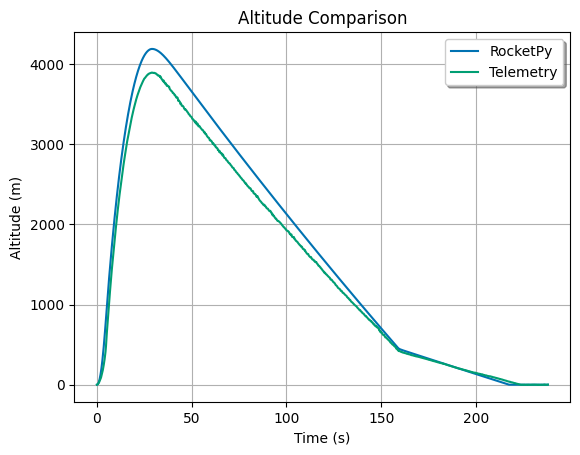

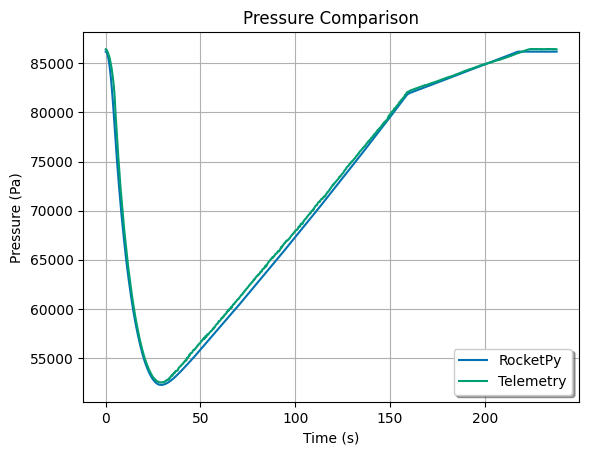

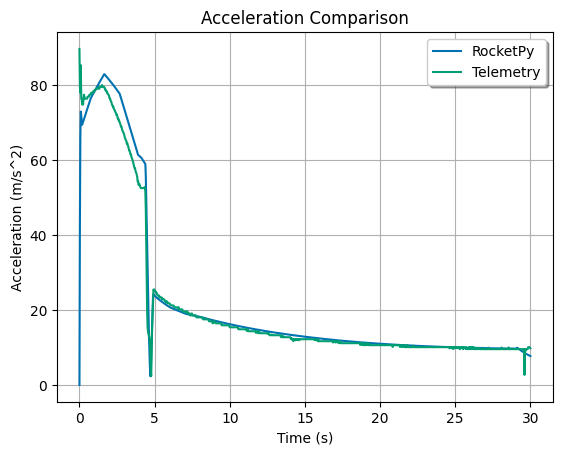

In [13]:
# Altitude comparison
Function.compare_plots(
    [
        (test_flight.altitude, "RocketPy"),
        (cots_altimeter_flight.altitude, "Telemetry"),
    ],
    title="Altitude Comparison",
    xlabel="Time (s)",
    ylabel="Altitude (m)",
    lower=0,
    # upper=30,
)

# Pressure comparison
Function.compare_plots(
    [
        (test_flight.pressure, "RocketPy"),
        (cots_altimeter_flight.pressure, "Telemetry"),
    ],
    title="Pressure Comparison",
    xlabel="Time (s)",
    ylabel="Pressure (Pa)",
    lower=0,
    # upper=30,
)

# Latitude comparison
# Function.compare_plots(
#     [
#         (test_flight.latitude, "RocketPy"),
#         (cots_altimeter_flight.latitude, "Telemetry"),
#     ],
#     title="Latitude Comparison",
#     xlabel="Time (s)",
#     ylabel="Latitude (deg)",
#     lower=0,
#     # upper=30,
# )

# Longitude comparison
# Function.compare_plots(
#     [
#         (test_flight.longitude, "RocketPy"),
#         (cots_altimeter_flight.longitude, "Telemetry"),
#     ],
#     title="Longitude Comparison",
#     xlabel="Time (s)",
#     ylabel="Longitude (deg)",
#     lower=0,
#     # upper=30,
# )


# Convert "deceleration" to "acceleration" for comparison
def absolute_cots_acceleration(x):
    return abs(cots_altimeter_flight.acceleration(x))


# Acceleration comparison
Function.compare_plots(
    [
        (test_flight.acceleration, "RocketPy"),
        (Function(absolute_cots_acceleration), "Telemetry"),
    ],
    title="Acceleration Comparison",
    xlabel="Time (s)",
    ylabel="Acceleration (m/s^2)",
    lower=0,
    upper=30,
)